In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import polyphase as phase
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
M = [5,5,1]
chi = [1, 0.5, 0.5]
#chi = [1, 0.5, 1]

configuration = {'M':M, 'chi':chi}

meshsize = 100
kwargs = {
    'flag_refine_simplices':True,
    'flag_lift_label': True,
    'use_weighted_delaunay': False,
    'flag_remove_collinear' : False, 
    'beta':1e-4, # not used 
    'flag_make_energy_paraboloid': True, 
    'pad_energy': 1,
    'flag_lift_purecomp_energy': False,
    'threshold_type':'uniform',
    'thresh_scale':0.1*meshsize,
    'lift_grid_size':meshsize,
    'verbose' : True
 }
out = phase.serialcompute(configuration,meshsize, **kwargs) 


3-dimensional grid generated at 0.07s
Energy computed at 0.10s
Making energy manifold a paraboloid with 1x padding of 59.28 maximum energy
Energy is corrected at 0.23s
Convexhull is computed at 0.23s
Using 1.43E-01 as a threshold for Laplacian of a simplex
Total of 325 simplices in the convex hull
Simplices are labelled at 0.42s
Labels are lifted at 0.48s
Total 0/325 coplanar simplices
Computation took 0.48s


<IPython.core.display.Javascript object>


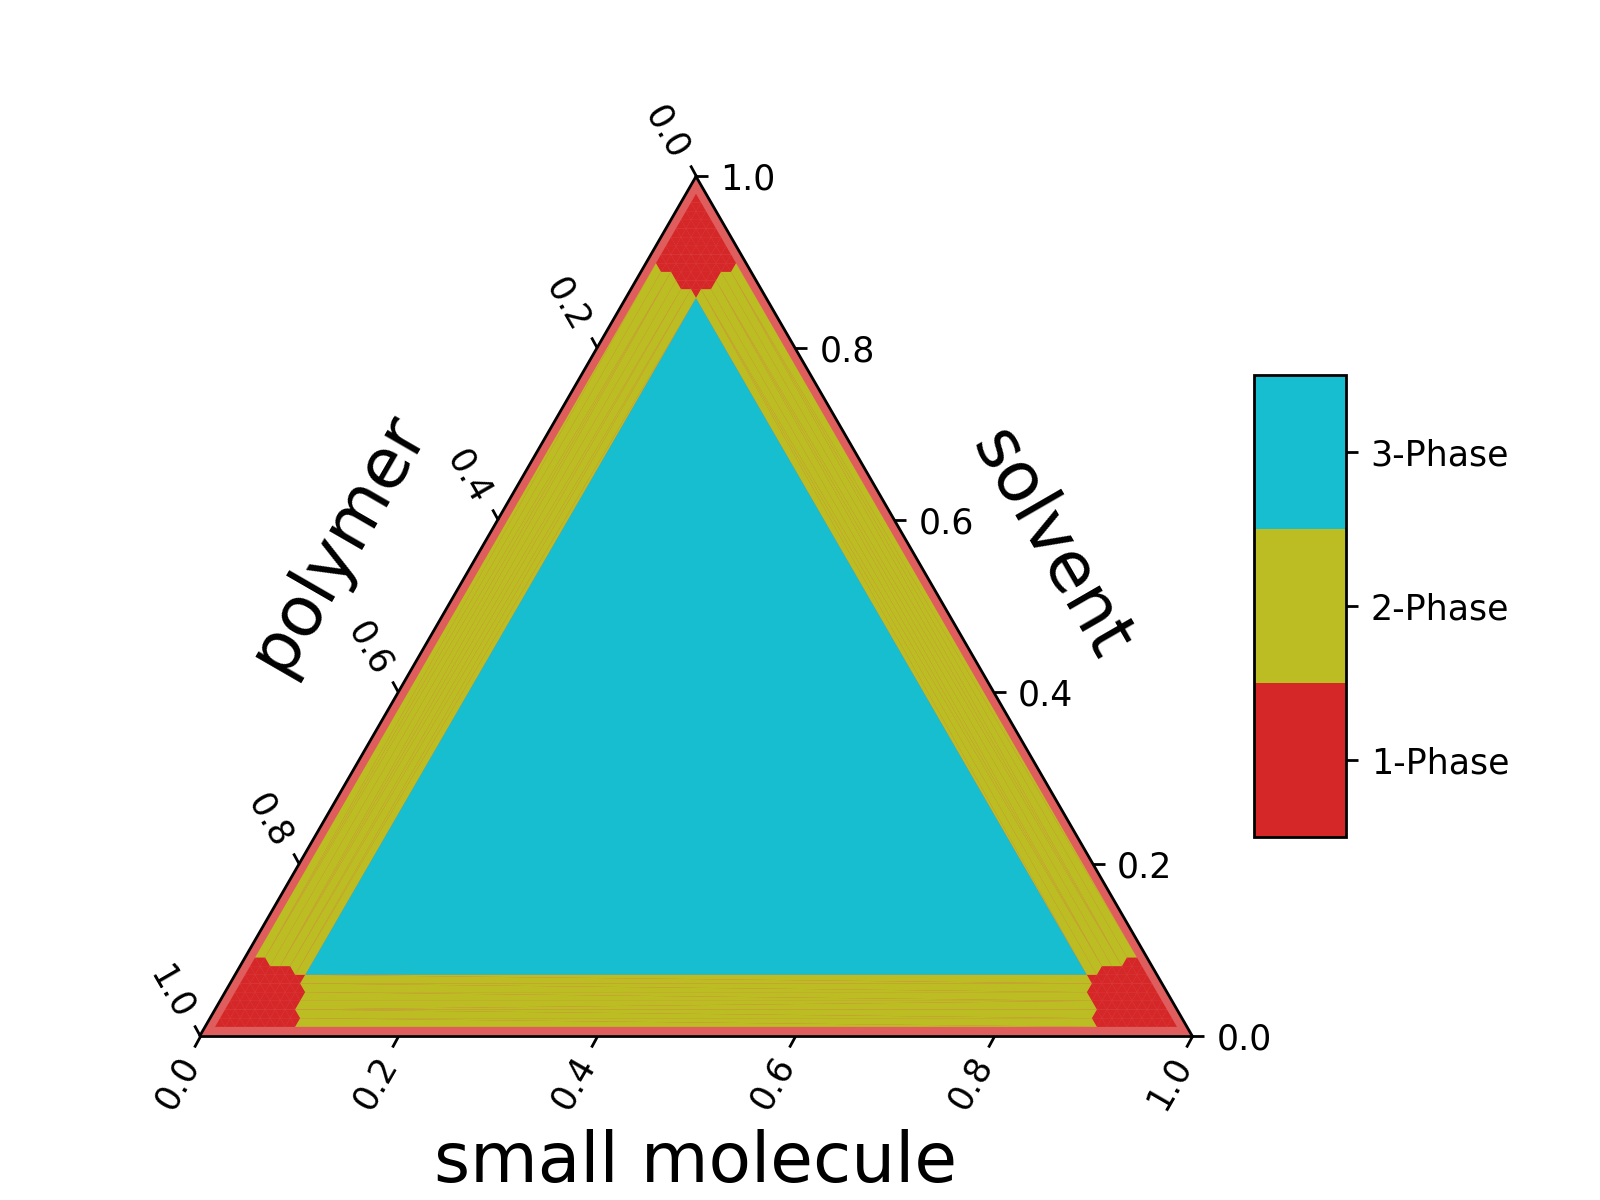

In [4]:
grid = out['grid']
num_comps = out['num_comps']
simplices = out['simplices']
energy = out['energy']

# phase.plot_lifted_label_ternary(out['output'])
phase.plot_mpltern(grid, simplices, num_comps)
plt.show()

<IPython.core.display.Javascript object>


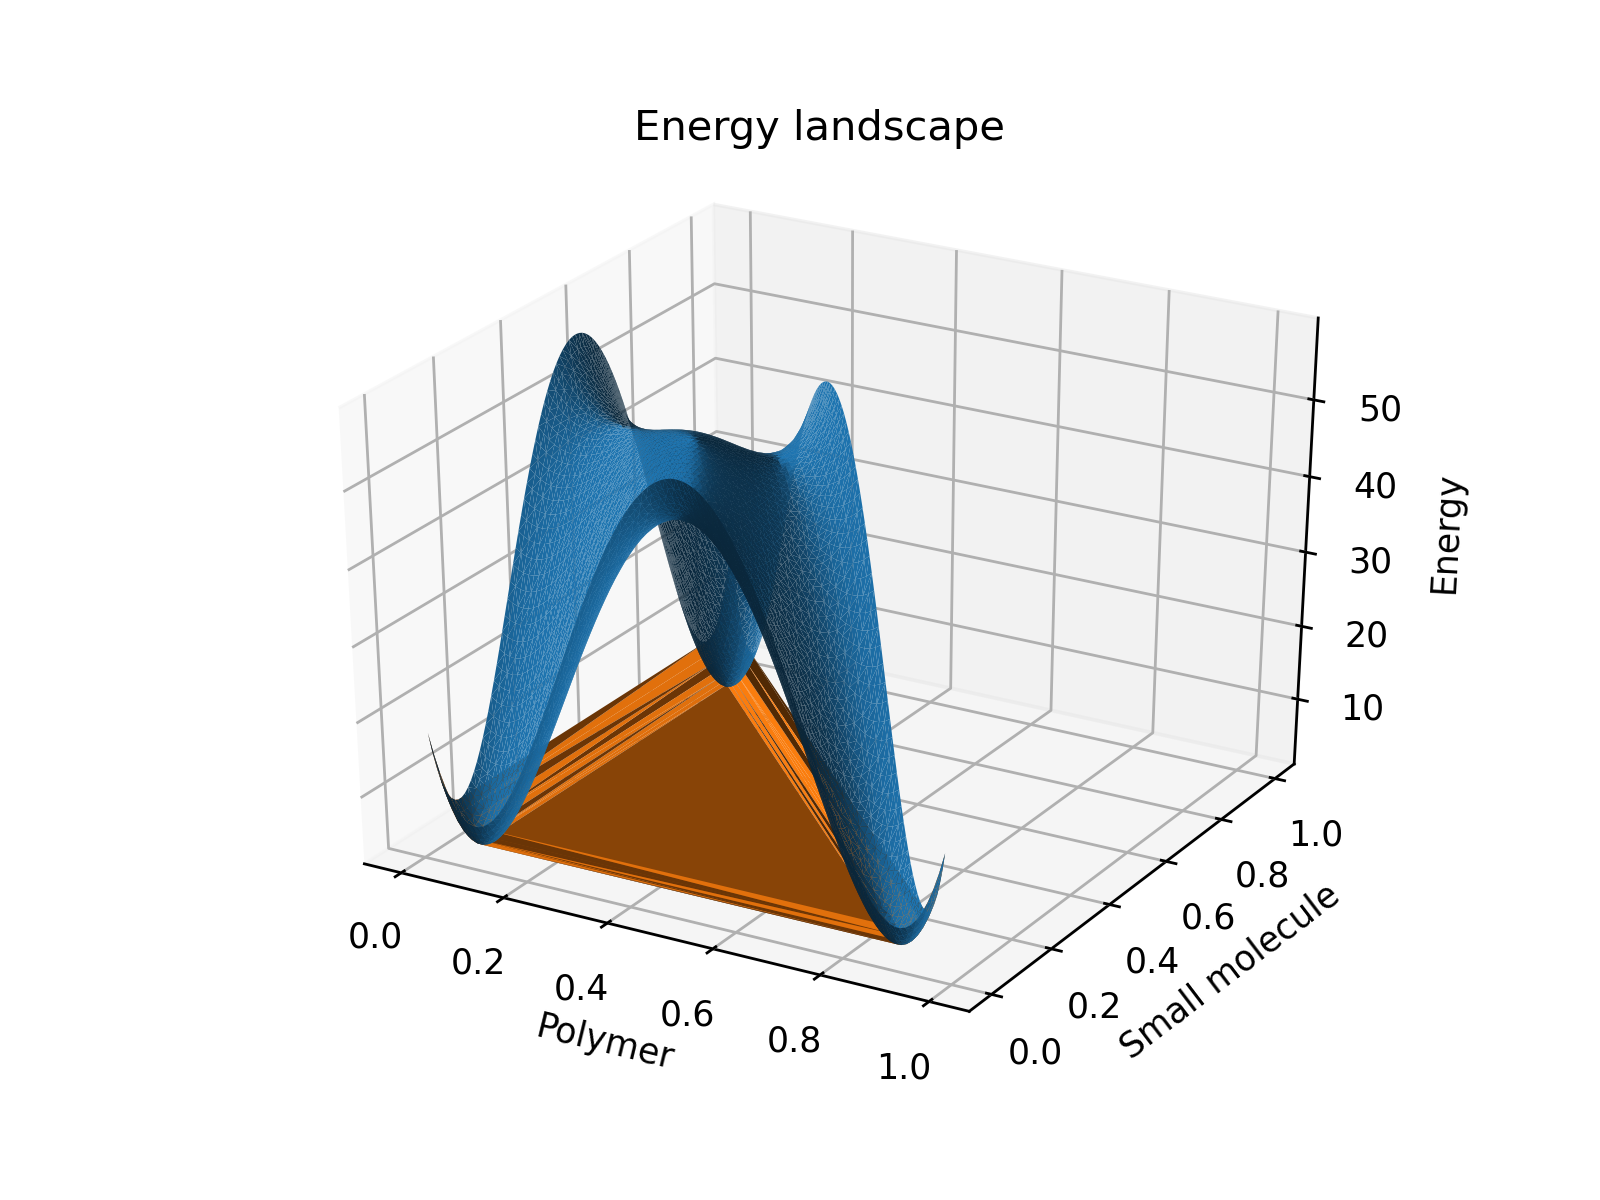

In [5]:
fig,ax = plt.subplots(subplot_kw={'projection':'3d'})
phase.plot_energy_landscape(out, mode='full', ax = ax)
phase.plot_energy_landscape(out, mode='convex_hull', ax = ax)
plt.show()

<IPython.core.display.Javascript object>


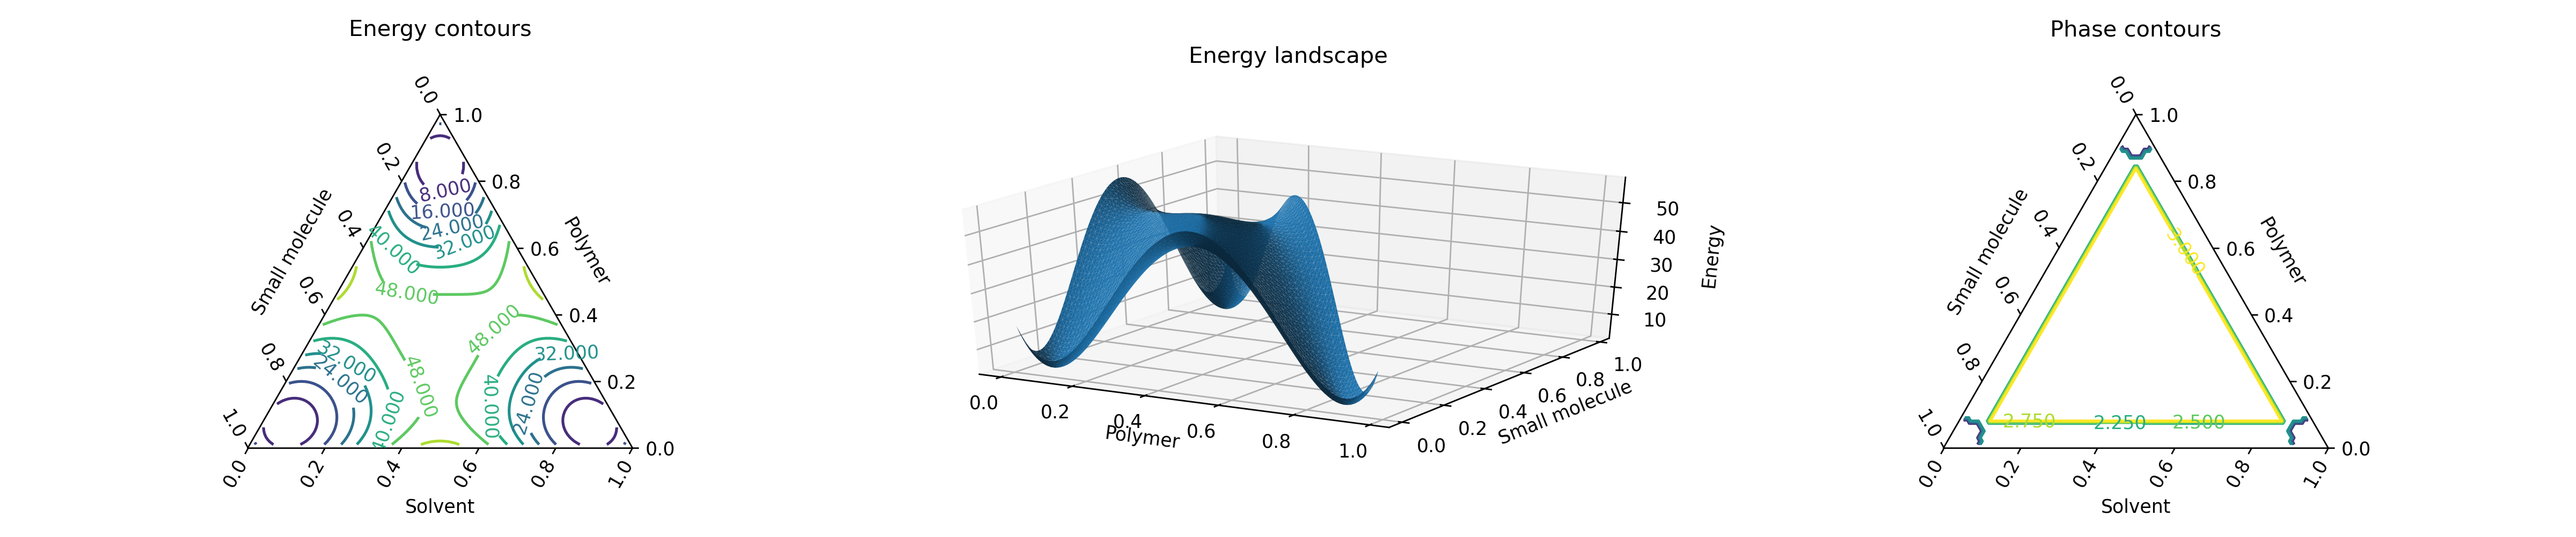

In [6]:
def plt_ternary_surface(grid, energy, num_comps):
    fig = plt.figure(figsize=(3*4*1.6,4))
    ax1 = fig.add_subplot(1,3,2, projection='3d')
    ax1.plot_trisurf(grid[0,:], grid[1,:], energy, linewidth=0.01, antialiased=True)
    ax1.set_xlabel('Polymer')
    ax1.set_ylabel('Small molecule')
    ax1.set_zlabel('Energy')
    ax1.set_title('Energy landscape', pad=42)
    
    ax2 = fig.add_subplot(1, 3, 1, projection='ternary')
    cs = ax2.tricontour(grid[0,:], grid[1,:], grid[2,:], energy)
    ax2.set_title("Energy contours", pad=42)
    ax2.clabel(cs)
    ax2.set_tlabel('Polymer')
    ax2.set_llabel('Small molecule')
    ax2.set_rlabel('Solvent')

    ax2.taxis.set_label_position('tick1')
    ax2.laxis.set_label_position('tick1')
    ax2.raxis.set_label_position('tick1')
    
    ax2 = fig.add_subplot(1, 3, 3, projection='ternary')
    cs = ax2.tricontour(grid[0,:], grid[1,:], grid[2,:], num_comps)
    ax2.set_title("Phase contours", pad=42)
    ax2.clabel(cs)
    ax2.set_tlabel('Polymer')
    ax2.set_llabel('Small molecule')
    ax2.set_rlabel('Solvent')

    ax2.taxis.set_label_position('tick1')
    ax2.laxis.set_label_position('tick1')
    ax2.raxis.set_label_position('tick1')
    
    plt.tight_layout()
    return

labels = out['output'].loc['label',:].to_numpy()
boundary_points= np.asarray([phase.is_boundary_point(x) for x in grid.T])
plt_ternary_surface(grid[:,~boundary_points], energy[~boundary_points], labels[~boundary_points])
#plt.savefig('../figures/notebooks/{}.png'.format(m), dpi=500, bbox_inches='tight')
plt.show()

In [7]:
CHI = phase._utri2mat(configuration['chi'],3)
def threecomp_gradphi_FH(x, beta=0):
    dEdx1 = (1/M[0])*(1+np.log(x[0])) - (1/M[2])*(1+np.log(x[2])) + CHI[0,1]*x[0] +\
    CHI[0,2] - 2*CHI[0,2]*x[0] - CHI[0,2]*x[1] - CHI[1,2]*x[1] + beta*((1/x[2]**2) - (1/x[0]**2))
    
    dEdx2 = (1/M[1])*(1+np.log(x[1])) - (1/M[2])*(1+np.log(x[2])) + CHI[0,1]*x[0] -\
    CHI[0,2]*x[0] + CHI[1,2] - 2*CHI[1,2]*x[1]  - CHI[1,2]*x[0]+ beta*((1/x[2]**2) - (1/x[1]**2))
    
    return [dEdx1, dEdx2]

def _grad_polynomial(x):
    
    grad = 2*(x-0.1)*(0.9-x)*(1-2*x)
    
    return grad*1e3

def polynomial_gradient(x,**kwargs):
    grad = []
    for xi in x[:2]:
        grad.append(_grad_polynomial(xi))
        
    return grad

analytic_gradient = lambda phi : polynomial_gradient(phi)

In [8]:
import matplotlib.tri as mtri

class CentralDifference:
    """Compute central difference gradinet of energy
    Works only for a 3-dimensional grid or a ternary system
    change the energy formulation
    """
    def __init__(self, grid, energy):
        if callable(energy):
            self.func = energy
        else:
            triang = mtri.Triangulation(grid[0,:], grid[1,:])
            self.interp_lin = mtri.LinearTriInterpolator(triang, energy)

    def __call__(self,phi, h = 1e-3):
        """
        x,y : coordinates (float)
        h   : gridspacing (float)

        """
        p1,p2,p3 = phi
        f_right = self.func([p1+h,p2,1-p1-h-p2])
        f_left = self.func([p1-h,p2,1-p1+h-p2])
        df_dx = (f_right - f_left)/2*h
        
        f_right = self.func([p1,p2+h,1-p1-h-p2])
        f_left = self.func([p1,p2-h,1-p1+h-p2])
        df_dy = (f_right - f_left)/2*h
        
        return [df_dx, df_dy]
    
    def plot_interpolated_energy(self):
        xi, yi = np.meshgrid(np.linspace(0, 1, 20), np.linspace(0, 1, 20))
        z = self.func(xi, yi)
        fig, ax = plt.subplots()
        ax.contourf(xi, yi, z)
        plt.show()

delta = np.linalg.norm(grid[:2,0] - grid[:2,1])
energy_func = lambda x : phase.polynomial_energy(x)
centraldiff_gradient = CentralDifference(grid, energy_func)    
df = np.asarray([centraldiff_gradient(phi, h = delta) for phi in grid.T])

Angle at vertex 0 is 2.75 degrees
Angle at vertex 1 is 8.64 degrees
Angle at vertex 2 is 2.75 degrees


<IPython.core.display.Javascript object>


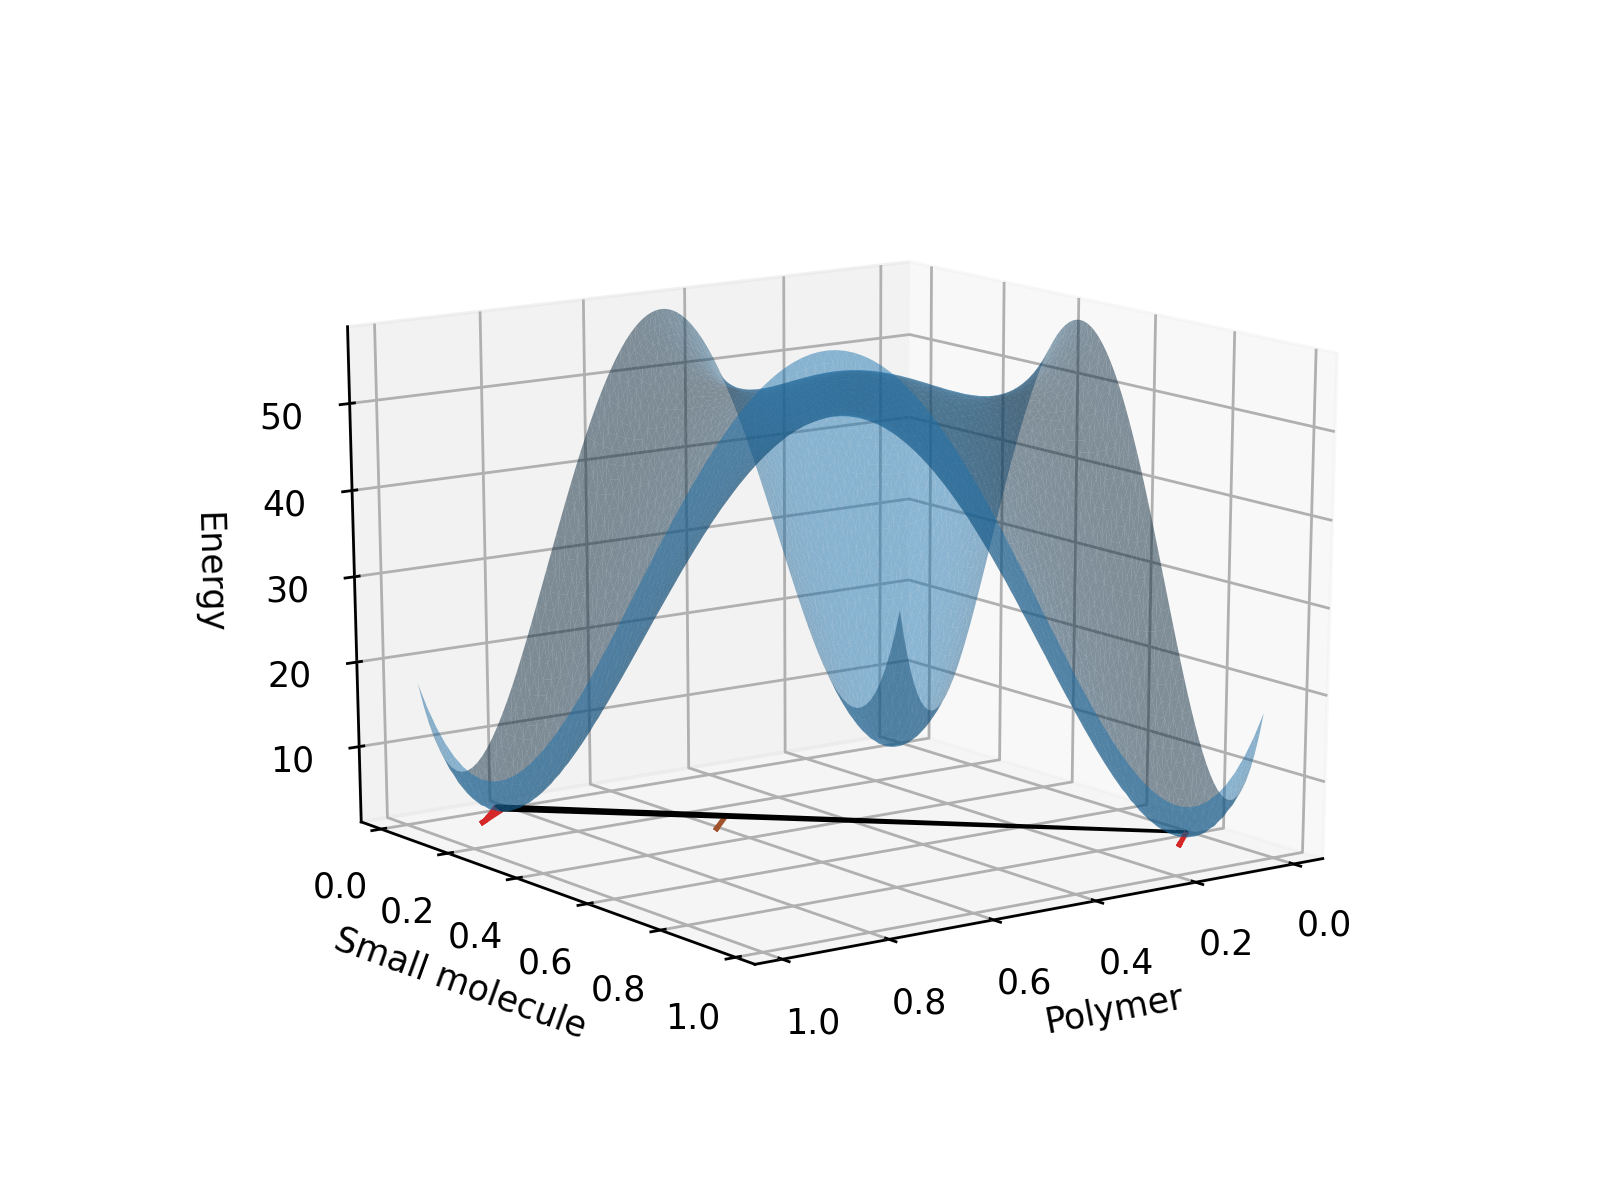

<IPython.core.display.Javascript object>


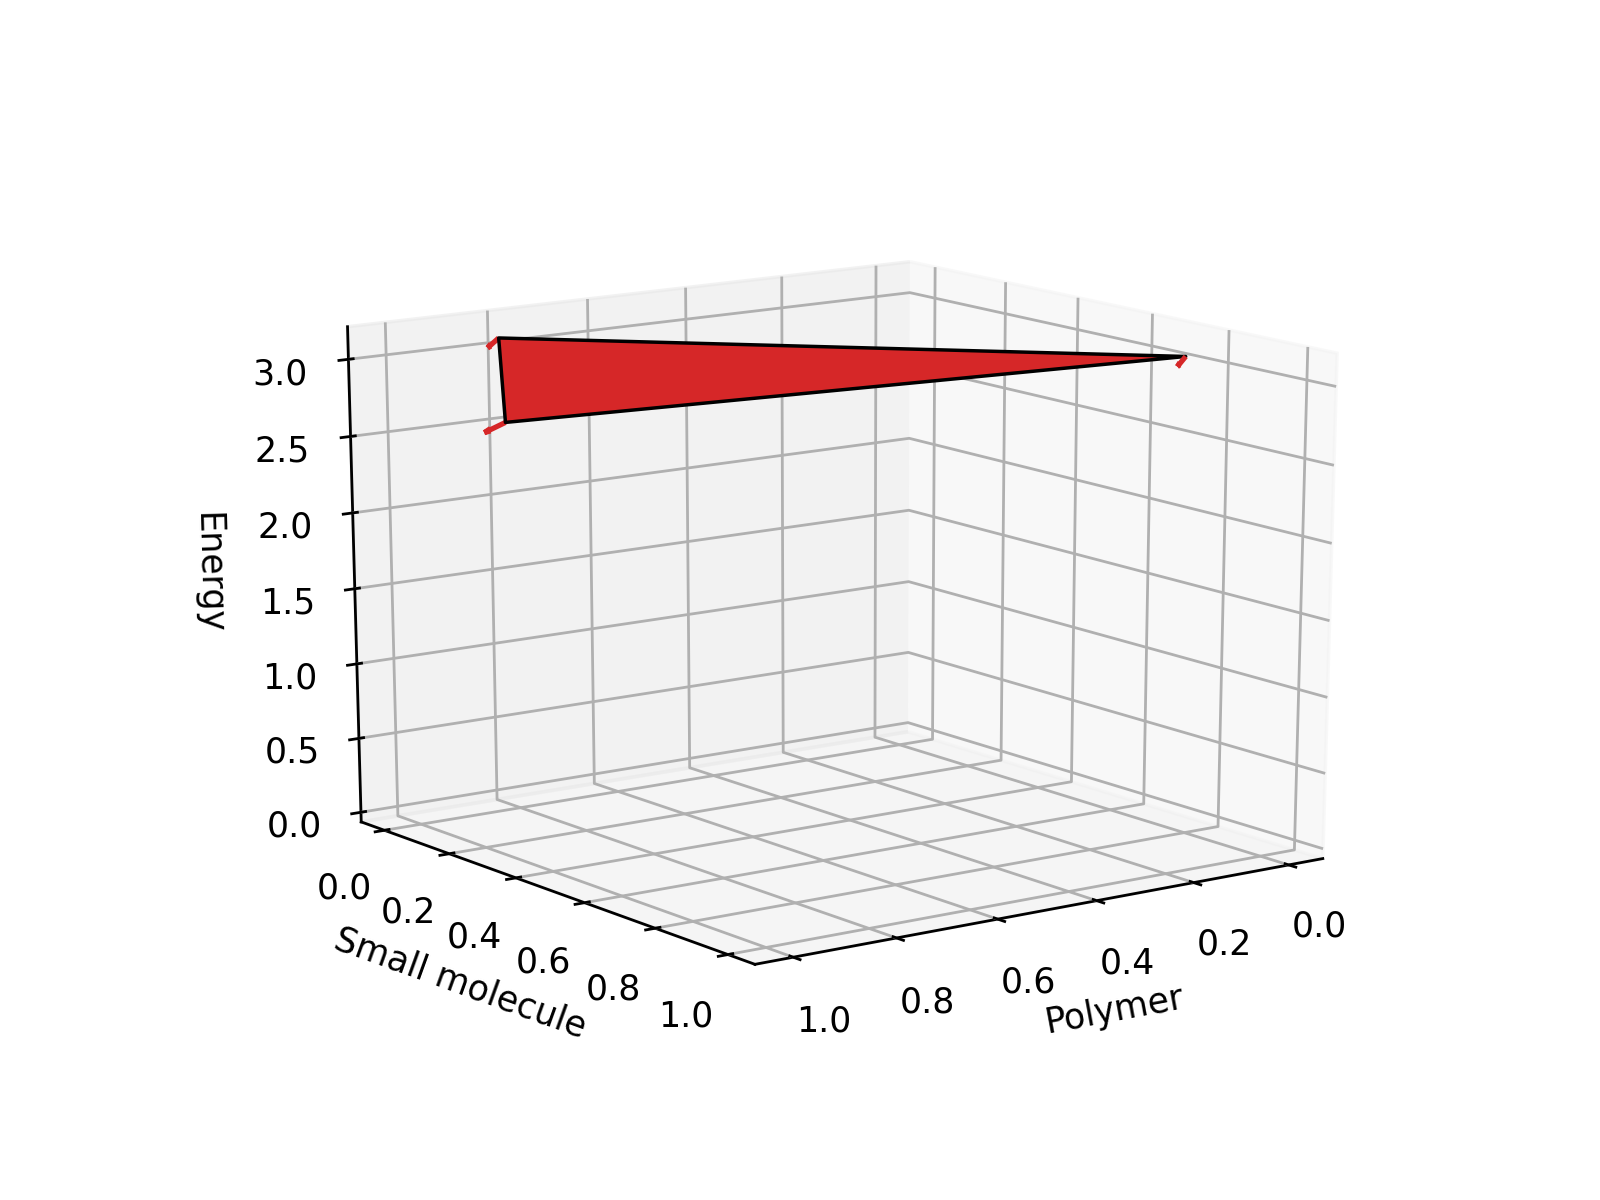

In [9]:
test = phase.TestAngles(out,analytic_gradient,phase=2,**kwargs)
test_out = test.get_angles()
for key, value in test_out['thetas'].items():
    print('Angle at vertex {} is {:.2f} degrees'.format(key, value[2]))

fig = test.visualize(required=[1,2])
plt.show()
fig = test.visualize(required=[2])
plt.show()

<IPython.core.display.Javascript object>


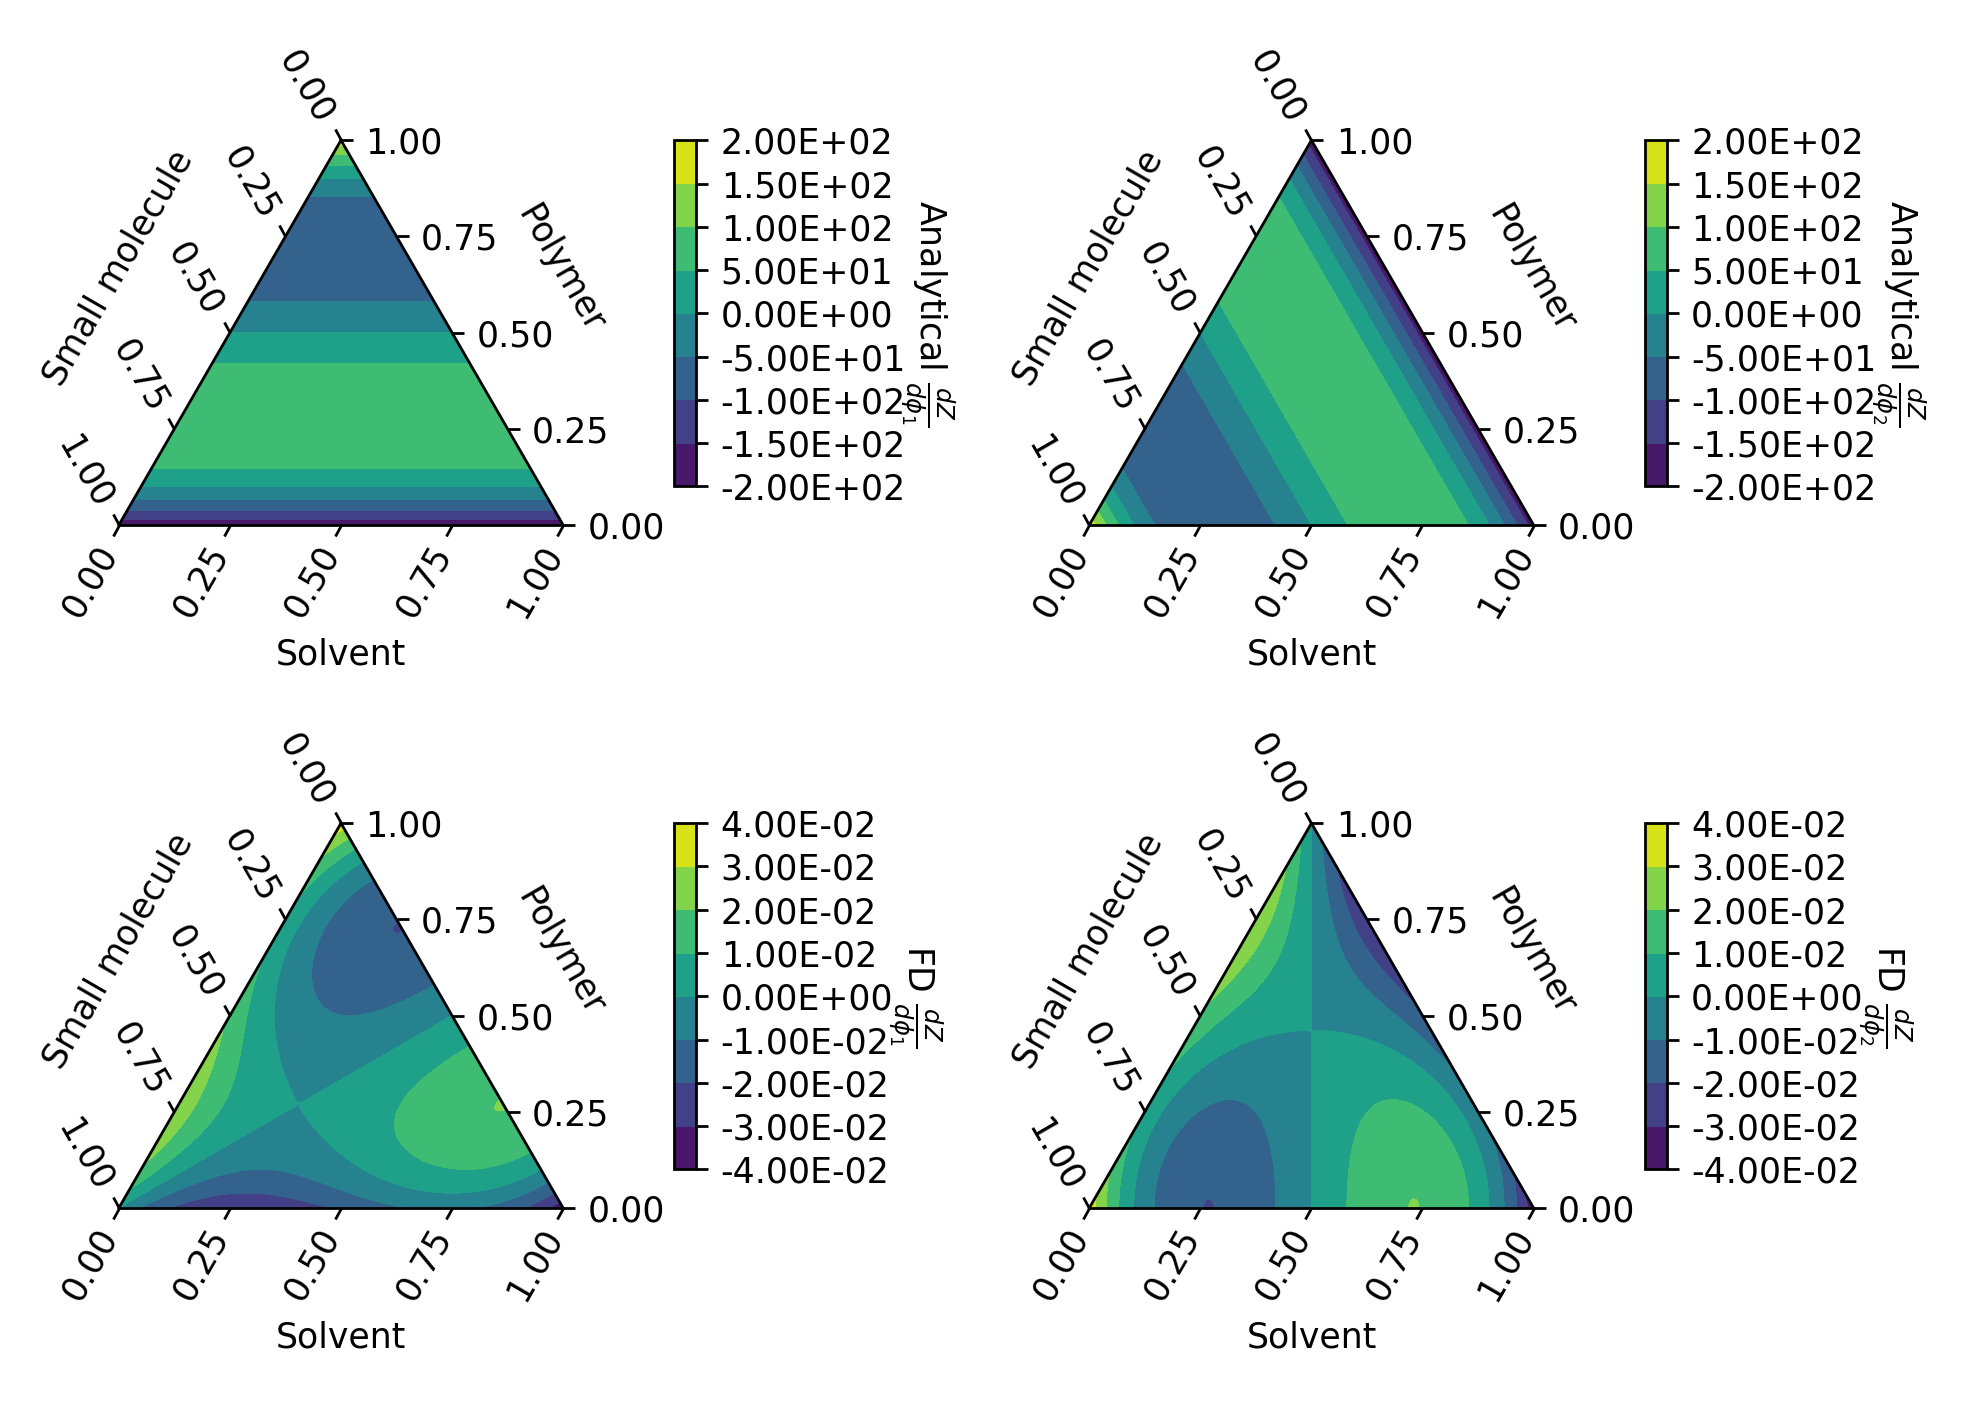

In [11]:
# Compare two gradient fields

def plot_gradient_field(grid, gradient, ax):
    fig = plt.gcf()
    cs = ax.tricontourf(grid[0,:], grid[1,:], grid[2,:], gradient)
    cax = ax.inset_axes([1.25, 0.1, 0.05, 0.9], transform=ax.transAxes)
    cbar = fig.colorbar(cs, cax=cax)
    cbar.ax.set_yticklabels(["{:.2E}".format(i) for i in cbar.get_ticks()])
    
    ax.set_tlabel('Polymer')
    ax.set_llabel('Small molecule')
    ax.set_rlabel('Solvent')

    ax.taxis.set_label_position('tick1')
    ax.laxis.set_label_position('tick1')
    ax.raxis.set_label_position('tick1')

    return ax, cbar

fig = plt.figure()
fig.subplots_adjust(hspace=1, wspace=0.8)

grad = np.asarray([analytic_gradient(x) for x in grid.T])

ax = fig.add_subplot(2,2,1,projection='ternary')
ax,cbar = plot_gradient_field(grid, grad[:,0], ax)
cbar.set_label(r'Analytical $\frac{dZ}{d\phi_1}$', rotation=270, va='baseline')

ax = fig.add_subplot(2,2,2,projection='ternary')
ax,cbar = plot_gradient_field(grid, grad[:,1], ax)
cbar.set_label(r'Analytical $\frac{dZ}{d\phi_2}$', rotation=270, va='baseline')

ax = fig.add_subplot(2,2,3,projection='ternary')
ax,cbar = plot_gradient_field(grid, np.nan_to_num(df[:,0]), ax)
cbar.set_label(r'FD $\frac{dZ}{d\phi_1}$', rotation=270, va='baseline')

ax = fig.add_subplot(2,2,4,projection='ternary')
ax,cbar = plot_gradient_field(grid,np.nan_to_num(df[:,1]), ax)
cbar.set_label(r'FD $\frac{dZ}{d\phi_2}$', rotation=270, va='baseline')
plt.tight_layout()
plt.show()